# Experiment with generating semantic structured data from a PDF file


In [3]:
import json

from adobe.pdfservices.operation.auth.service_principal_credentials import ServicePrincipalCredentials
from adobe.pdfservices.operation.pdf_services import PDFServices


def load_pdf_service_credentials() -> dict:
    with open("pdfservices-api-credentials.json") as cred_file:
        data = json.load(cred_file)
    return data["client_credentials"]


# Read credentials from JSON file
creds = load_pdf_service_credentials()
credentials = ServicePrincipalCredentials(client_id=creds["client_id"], client_secret=creds["client_secret"])

# Create an instance of PDF Services
adobe_client = PDFServices(credentials=credentials)

## Generate JSON structured data from a PDF file

We use the PDF Services API to generate JSON structured data from a PDF file. This is a remote job that might take a while to complete.


In [4]:
FILE_PATH = "./tmp/files/example.pdf"

In [5]:
import io
import zipfile

from adobe.pdfservices.operation.io.cloud_asset import CloudAsset
from adobe.pdfservices.operation.io.stream_asset import StreamAsset
from adobe.pdfservices.operation.pdf_services_media_type import PDFServicesMediaType
from adobe.pdfservices.operation.pdfjobs.jobs.extract_pdf_job import ExtractPDFJob
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_pdf_params import ExtractPDFParams
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_renditions_element_type import (
    ExtractRenditionsElementType,
)
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.table_structure_type import TableStructureType
from adobe.pdfservices.operation.pdfjobs.result.extract_pdf_result import ExtractPDFResult

# Open and read the input PDF file
with open(FILE_PATH, "rb") as file:
    input_stream = file.read()

# Upload the source file as an asset
input_asset = adobe_client.upload(input_stream=input_stream, mime_type=PDFServicesMediaType.PDF)

# Set the parameters for extraction
extract_pdf_params = ExtractPDFParams(
    table_structure_type=TableStructureType.XLSX,
    elements_to_extract=[
        ExtractElementType.TEXT,
        ExtractElementType.TABLES,
    ],
    elements_to_extract_renditions=[ExtractRenditionsElementType.FIGURES],
)


# Create and submit the extraction job
extract_pdf_job = ExtractPDFJob(input_asset=input_asset, extract_pdf_params=extract_pdf_params)
location = adobe_client.submit(extract_pdf_job)
pdf_services_response = adobe_client.get_job_result(location, ExtractPDFResult)

result_asset: CloudAsset = pdf_services_response.get_result().get_resource()
stream_asset: StreamAsset = adobe_client.get_content(result_asset)


# Get the zip content
zip_content = stream_asset.get_input_stream()

zf = zipfile.ZipFile(io.BytesIO(zip_content))

In [36]:
import pandas as pd

json_data = json.loads(zf.read("structuredData.json"))

df = pd.DataFrame(json_data["elements"])

df.sample(10)


,Bounds,ObjectID,Page,Path,attributes,filePaths,Font,HasClip,Lang,Text,TextSize,ClipBounds,alternate_text
338,"[99.10000610351562, 186.5800018310547, 506.899...",1945,17.0,//Document/L[20]/LI[3]/LBody/Figure[2],"{'BBox': [99.11599999999817, 186.6269999999931...",[figures/fileoutpart44.png],NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,"[322.4499969482422, 87.58000183105469, 532.300...",1709,6.0,//Document/L[6]/LI/LBody/Figure[4],"{'BBox': [322.42699999999604, 87.6306999999978...",[figures/fileoutpart17.png],NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,"[135.6999969482422, 256.42999267578125, 452.39...",1972,18.0,//Document/L[21]/LI[3]/LBody/Figure,"{'BBox': [135.71399999999994, 256.463999999992...",[figures/fileoutpart46.png],NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,"[81.10000610351562, 82.67999267578125, 305.149...",1708,6.0,//Document/L[6]/LI/LBody/Figure[3],"{'BBox': [81.11669999999867, 82.71089999999822...",[figures/fileoutpart16.png],NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,"[99.26400756835938, 375.0500030517578, 323.685...",1889,15.0,//Document/P[8],"{'LineHeight': 13.25, 'SpaceAfter': 5.125}",NaN,"{'alt_family_name': 'Calibri', 'embedded': Tru...",True,nl,Smeermiddel: PASTA MONTAGE MOLYKOTE 1000,11.039993,NaN,NaN
309,"[99.25, 199.5800018310547, 166.8000030517578, ...",1897,15.0,//Document/Reference[3]/Figure,"{'BBox': [99.23599999999715, 199.5859999999957...",[figures/fileoutpart37.png],NaN,NaN,NaN,NaN,NaN,NaN,Afbeelding QR-code
305,"[99.25, 307.3300018310547, 166.8000030517578, ...",1891,15.0,//Document/Reference[2]/Figure,"{'BBox': [99.23599999999715, 307.3419999999896...",[figures/fileoutpart36.png],NaN,NaN,NaN,NaN,NaN,NaN,Afbeelding QR-code
257,"[97.58399963378906, 334.79840087890625, 269.63...",1797,11.0,//Document/Aside[4]/P[3],{'LineHeight': 12},NaN,"{'alt_family_name': 'Arial', 'embedded': False...",True,nl,DOP LUCHTKOPPELING KNST G1/2,9.960007,NaN,NaN
268,"[166.5500030517578, 396.8300018310547, 421.550...",1819,12.0,//Document/Figure[15],"{'BBox': [166.55299999999988, 396.857999999992...",[figures/fileoutpart27.png],NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,"[97.58399963378906, 321.5299987792969, 351.816...",1798,11.0,//Document/Aside[4]/P[4],"{'LineHeight': 13.25, 'SpaceAfter': 15.75}",NaN,"{'alt_family_name': 'Arial', 'embedded': False...",True,nl,Hergebruikte dop: DOP LUCHTKOPPELING KNST M16,9.960007,NaN,NaN


## Plot the distribution of content types

We can see in the plot below that the most common content type is "lbl" which is the text of the labels in the PDF.


In [37]:
CONTENT_TYPE_EXTRACTOR = r"/([^/]+?)(?:\[\d+\])?$"

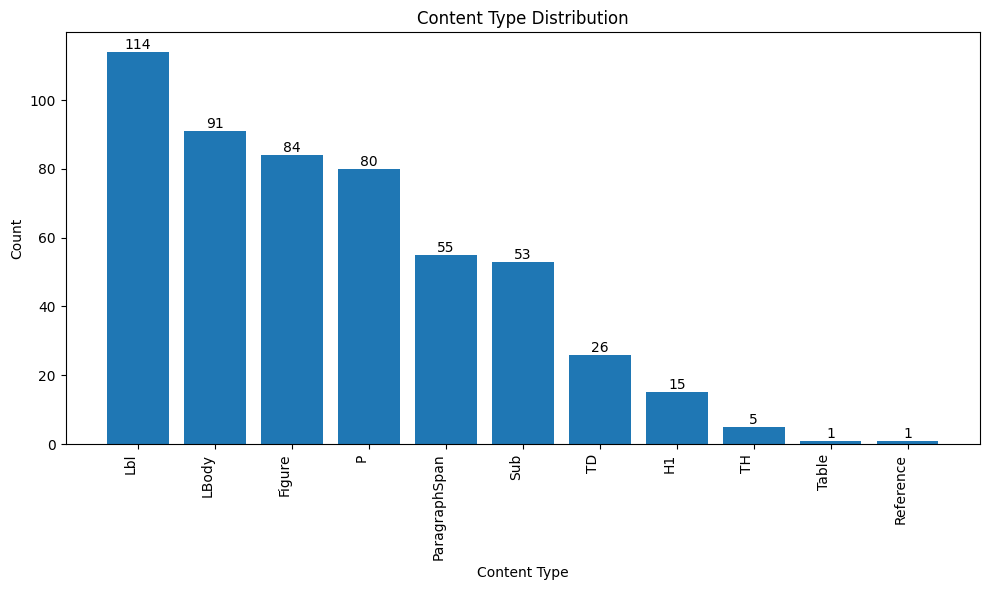

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Get stats about different content types from the Path column
path_stats = df["Path"].str.extract(CONTENT_TYPE_EXTRACTOR)[0].value_counts()

# Convert to numpy arrays to ensure type compatibility
x = np.arange(len(path_stats.index))
heights = path_stats.values.astype(float)
labels = path_stats.index.tolist()  # Convert index to list

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x, heights)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f"{int(height)}", ha="center", va="bottom")

# Customize the plot
plt.title("Content Type Distribution")
plt.xlabel("Content Type")
plt.ylabel("Count")

# Set x-axis labels
plt.xticks(x, labels, rotation=90, ha="right")  # Use the converted labels

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [63]:
from dotenv import dotenv_values
from google import genai

gemini_client = genai.Client(api_key=dotenv_values().get("GEMINI_API_KEY"))

In [64]:
from google.genai.types import (
    Content,
    GenerateContentConfig,
    Part,
)

# Find all figures in the dataframe
figures_mask = df["Path"].str.extract(CONTENT_TYPE_EXTRACTOR)[0] == "Figure"
figures = df[figures_mask]

# Loop through each figure
for idx, (row_hash, figure) in enumerate(figures.iterrows()):
    if not isinstance(figure["filePaths"], list) or len(figure["filePaths"]) == 0:
        continue

    if pd.notna(figure["alternate_text"]):
        continue

    # Extract the image path from the figure data
    image_path = figure["filePaths"][0]  # Gets path like 'figures/figure1.png'

    # Read the image file from the ZIP archive
    with zf.open(image_path) as image_file:
        image_data = image_file.read()

        response = gemini_client.models.generate_content(
            model="gemini-2.0-flash",
            config=GenerateContentConfig(
                system_instruction="""Generate the alternative text for this figure for accessibility purposes. Describe the meaning of the figure and the key components or elements shown.
                The text should be in Dutch. Be concise and to the point. Just the description of the figure, no introduction or other text.
                """,
            ),
            contents=[
                Content(
                    parts=[
                        Part.from_text(text="Here is the figure:"),
                        Part.from_bytes(data=image_data, mime_type="image/png"),
                    ],
                )
            ],
        )

        print(
            f"{float(idx + 1.0) / len(figures) * 100:.1f}%: {response.text.strip() if response.text else ''}"  # type: ignore
        )
        df.at[row_hash, "alternate_text"] = response.text

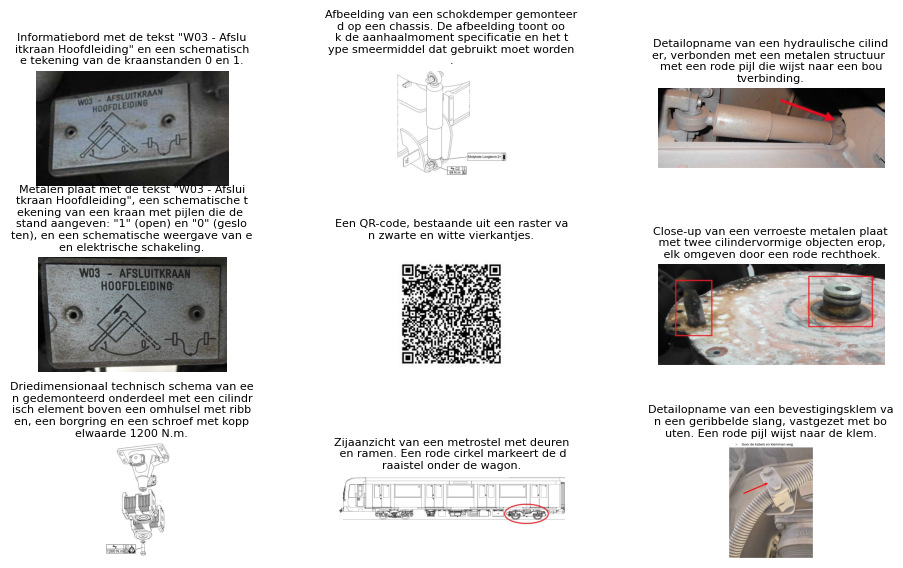

In [65]:
import io

import matplotlib.pyplot as plt
from PIL import Image

sample = df[df["alternate_text"].notna()].sample(min(9, len(df[df["alternate_text"].notna()])))

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 6))
fig.tight_layout(pad=3.0)  # Add padding between subplots

# Flatten the 2D array of axes for easier iteration
axes_flat = axes.flatten()

# For each sample row and corresponding axis
for idx, (_, row) in enumerate(sample.iterrows()):
    if idx >= len(axes_flat):  # In case we have fewer than 9 samples
        break

    # Get the image path and read image data
    image_path = row["filePaths"][0]
    with zf.open(image_path) as image_file:
        image_data = image_file.read()
        img = Image.open(io.BytesIO(image_data))

    # Plot image
    axes_flat[idx].imshow(img)
    axes_flat[idx].axis("off")  # Turn off axis labels

    # Add description as title, wrap text at 40 characters
    desc = row["alternate_text"]
    if desc is not None:
        wrapped_text = "\n".join([desc[i : i + 40] for i in range(0, len(desc), 40)])
        axes_flat[idx].set_title(wrapped_text, fontsize=8, wrap=True)

# Remove any empty subplots
for idx in range(len(sample), len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.show()


In [66]:
table_mask = df["Path"].str.extract(CONTENT_TYPE_EXTRACTOR)[0] == "Table"

# Get all tables from the dataframe
tables_df = df[table_mask]

# Add empty table_data column
df["table_data"] = None


# Load and display each table
for row_hash, row in tables_df.iterrows():
    excel_path = row["filePaths"][0]  # Get the Excel file path

    with zf.open(excel_path) as excel_file:
        table_df = pd.read_excel(excel_file)
        df.at[row_hash, "table_data"] = table_df.to_dict()

tables_df.sample()


,Bounds,ObjectID,Page,Path,attributes,filePaths,Font,HasClip,Lang,Text,TextSize,ClipBounds,alternate_text,table_data
65,"[56.48249816894531, 245.08999633789062, 532.21...",1495,1.0,//Document/Table,"{'BBox': [52.55789999999979, 234.9849999999933...",[tables/fileoutpart3.xlsx],NaN,NaN,NaN,NaN,NaN,"[56.48249816894531, 245.08999633789062, 532.21...",NaN,{'• SCHUUR ROL SCOTCH BRITE ROOD AVF _x000D__x...


In [75]:
columns_to_remove = ["ObjectID", "attributes", "Font", "HasClip", "Lang", "TextSize", "ClipBounds"]
markdown_df = df.drop(columns=columns_to_remove, errors="ignore").sort_values("Page")

response = gemini_client.models.generate_content(
    model="gemini-2.0-flash",
    config=GenerateContentConfig(
        system_instruction="""Generate markdown from the following data. Render each row in this csv as markdown item. I don't want a single table. I want a nicely formatted markdown document. So headings should be headings, and images should be images. etc.
        """,
    ),
    contents=[
        Content(
            parts=[
                Part.from_text(text=json.dumps(markdown_df.to_dict(orient="records"), indent=2)),
            ],
        )
    ],
)

In [77]:
response.text

'# Document\n\n![Logo van het Gemeentelijk Vervoerbedrijf Amsterdam (GVB), met een blauwe achtergrond, een wit gestileerd lijnensymbool en de witte letters "GVB".\n](figures/fileoutpart0.png)\n\n• RING M10 GEELP BORG SCHNORR (8) \n• RING-O PULSGEVER M5 (2) \n• BUFFER DWARS PIVOT-DRST M5 (2) \n• RING M12 TREP XC75 3L (3) \n• RING 22/27X1,5 CU DICHT DIN7603 (2) \n• RING AFDI L8 DIN EN ISO 7093-1 ST GEOMET (4) \n• LDRST ZONDER STROOMAFN TB2 COMP M5 (1) \n• MOERBORG M8 NFE25411  A2-70 (6) \n• RING BORG VS36 SCHNORR (1) \n• SCHOKBREKER LATERAAL DRST COMP M5 (1) \n• SCHOKBREKER VERTICAAL DRST COMP M5 (2) \n• AFDEKPLAAT ASPOT M5 (1) \n• PAKKING ISOLATIEPLAAT KOOLBORSTHDR M5 (1) \n• BOUT M8X20 8.8 TAP ELVZ DIN933 ISO4017 (4) \n• BORGRING VS 8 (Schnorr) (4) \n• RING M12 TY:S GEELP BORG SCHNORR (12) \n• RING M16 TY:S ZWART BORG SCHNORR (4) \n• RING M12 GEELP BORG NORDLOCK (8) \n• DEKSEL EN AW 6061 VOOR CONNECTOR M5 (2x) \n\n# Veiligheid \n\n![Groene cirkel met de tekst \'Veiligstel niveau\' en h

In [88]:
response = gemini_client.models.generate_content(
    model="gemini-2.0-flash",
    config=GenerateContentConfig(
        system_instruction="""Generate a short summary of the goal of the procedure in the following document in dutch.
        """,
    ),
    contents=[
        Content(
            parts=[
                Part.from_text(text=json.dumps(markdown_df.to_dict(orient="records"), indent=2)),
            ],
        )
    ],
)

response.text

'Het document beschrijft een gedetailleerde procedure voor het veilig verwijderen en vervangen van een draaistel (een onderstel met wielen) van een voertuig, inclusief alle benodigde stappen voor de mechanische, pneumatische en elektrische verbindingen, en het transportgereed maken van het oude draaistel.'

Our approach to get more relevant data to the user is to generate metadata like below for each document, including a short summary. This allows the LLM to analyze the metadata and intelligently determine which document, if any, is most relevant to the user's query.

```json
{
  "subject": "Vervangen draaistelsel",
  "summary": "Het document beschrijft een gedetailleerde procedure voor het veilig verwijderen en vervangen van een draaistel (een onderstel met wielen) van een voertuig, inclusief alle benodigde stappen voor de mechanische, pneumatische en elektrische verbindingen, en het transportgereed maken van het oude draaistel.",
  "document": "./tmp/files/example.pdf",
  "images": [
    {
      "path": "./tmp/files/figures/figure1.png",
      "description": "Een afbeelding van een draaistel",
      "page": 1
    }
  ]
}
```
